# Deep Learning 2024 - Assignment 2: Neural Networks
Instructed by Jukka Komulainen (jukka.komulainen@oulu.fi)

## Outline
#### In this assignment, you will learn:
* Basics of (deep) feedforward neural networks (NNs)
* Building a simple NN from scratch using NumPy to understand how forward/back propagation and optimization works
* Gradient check using finite-difference approximation
* Mini-batch gradient descent with momentum
* Regularization and simple hyperparameter tuning methods to improve the performance of NNs

#### Tasks & grading (<span style="color:green">10 points</span>)

* **Part 1: Importing libraries, loading and preprocessing the training and testing data**
* **Part 2: Build neural network and implement its forward and backward propagation (<span style="color:green">5.5 points</span>)**
  * 2.1 Check the structure of dataset
  * 2.2 Construct model and implement forward propagation (<span style="color:green">3 points</span>)
    * Initialize model parameters (<span style="color:green">0.5 points</span>)
    * Define activation functions (<span style="color:green">1.5 points</span>)
    * Implement forward propagation (<span style="color:green">1 point</span>)
  * 2.3 Loss function computation and backward propagation (<span style="color:green">2.5 points</span>)
    * Implement cross-entropy loss function (<span style="color:green">0.5 points</span>)
    * Implement backward propagation (<span style="color:green">2 points</span>)
    * Extended Reading: Gradient check using finite-difference approximation
* **Part 3: Training and evaluation of your neural network (<span style="color:green">2 points</span>)**
  * 3.1 Training your network (<span style="color:green">1.5 points</span>)
  * 3.2 Evaluating the performance of your model (<span style="color:green">0.5 points</span>)

* **Part 4: Regularization and hyperparameter tuning (<span style="color:green">2.5 points</span>)**
  * 4.1 Implement weight decay loss and its backward propagation  (<span style="color:green">1.5 points</span>)
  * 4.2 Hyperparameter tuning (<span style="color:green">1 point</span>)

#### Environment
Python 3, Numpy, matplotlib, sklearn

#### Dataset
* [**Fashion-MNIST**](https://github.com/zalandoresearch/fashion-mnist)
is a dataset of Zalando's article images — consisting of a training set of 60,000 samples and a test set of 10,000 samples. Each samples is a 28x28 grayscale image, associated with a label corresponding to 10 classes. Intention of the Fashion-MNIST dataset is to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits. The Fashion-MNIST dataset gives you more room to wiggle your experiments.

#### Hints
* To find the place where you have to insert your solution, hit Crtl + F and search for **TODO:**. You are **NOT** supposed to modify the code of other parts.
* **Be careful with the shape** of your tensors (e.g. the weights and gradients) in your implementation. Double-check and make sure that the dimensions match the computations, especially in the case of matrix multiplication.
* You can check the correctness of your code by comparing your intermediate outputs with the provided **<span style="color:green">reference results</span>**. **Please remember to do this in every step in order to avoid cumulating errors in your implementation.**

## Part 1: Importing libraries, loading and preprocessing the training and test data
**You don't need to change any of the code in this part!**

In [3]:
# You will mainly use NumPy to construct your NN
import numpy as np
import matplotlib, time, copy, os, requests, zipfile, sys
# Matplotlib for displaying images
import matplotlib.pyplot as plt
# Off-the-shelf evaluation functions provided by sklearn
from sklearn.metrics import confusion_matrix, accuracy_score

### Downloading the Fashion-MNIST dataset from OneDrive
Installing first [onedrivedownloader](https://pypi.org/project/onedrivedownloader/) package for downloading the data.

In [4]:
!pip install onedrivedownloader

Downloading the Fashion-MNIST dataset.

In [5]:
from onedrivedownloader import download

link = 'https://unioulu-my.sharepoint.com/:u:/g/personal/jukmaatt_univ_yo_oulu_fi/Ebf8gdfru91OngYyFwRtAaYB6MNFdx-HExiy8RApgVwnwA?e=FuS4GI'

if not os.path.exists('./data_hw2/fashion_mnist_npy'):
    print('Downloading dataset')
    download(link, filename="./fashion_mnist_npy.zip", unzip=True, unzip_path='./data_hw2/fashion_mnist_npy')

### Defining functions for preprocessing the training & testing data

In [6]:
def reshape_train_data(X):
    ''' Input training data has shape (60000, 28, 28)
        Input testing data has shape (10000, 28, 28)
        where:
        60000 is the numbers of input training samples
        10000 is the numbers of input testing samples
        similar to MNIST, resolution of each sample is 28 x 28
    '''
    samples, H, W = X.shape
    # Reshape input volume to (sample, 784), which means that the size of your NN input layer will be 784
    # We scale the grayscale values by dividing them by 255, which will help to improve the training performance
    return X.reshape(samples, H * W).T / 255

def one_hot_vector(x, num_classes):
    # Converting categorical labels into a binary vector
    return np.eye(num_classes)[x].T

### Preprocessing the dataset

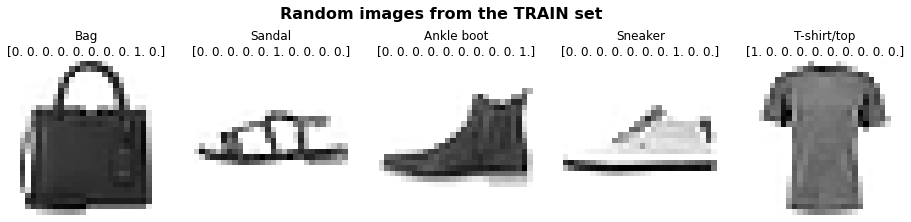

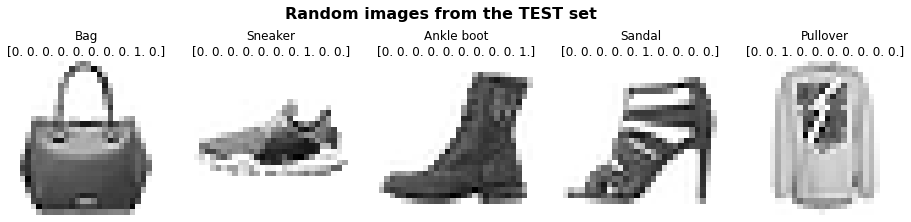

In [7]:
PATH = os.path.join('data_hw2', 'fashion_mnist_npy')

# The actual meaning of your class labels.
# E.g. an output one-hot vector is [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.] represents a dress
label_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Load the training samples
X_train = np.load(os.path.join(PATH, 'train_data.npy'))
# Load the test samples
X_test = np.load(os.path.join(PATH, 'test_data.npy'))
# Load the training labels
Y_train = np.load(os.path.join(PATH, 'train_labels.npy'))
# Load the test labels
Y_test = np.load(os.path.join(PATH, 'test_labels.npy'))

# Get the number of classes
num_classes = len(label_names)
# Get the number of training images and their resolution
num_trains, HEIGHT, WIDTH = X_train.shape

# Reshape the training and test data
X_train, X_test = reshape_train_data(X_train), reshape_train_data(X_test)

# Create one-hot vector for the training and test labels
Y_train, Y_test = one_hot_vector(Y_train, num_classes), one_hot_vector(Y_test, num_classes)

# The following code load randomly some of the training and test images and the corresponding one-hot vectors for checking
fig_train, ax_train = plt.subplots(figsize=(16, 8), nrows=1, ncols=5)
fig_train.suptitle("Random images from the TRAIN set", y=0.73, fontsize=16, fontweight='bold')

fig_test, ax_test = plt.subplots(figsize=(16, 8), nrows=1, ncols=5)
fig_test.suptitle("Random images from the TEST set", y=0.73, fontsize=16, fontweight='bold')

np.random.seed(666)
for idx in range(5):
    i, j = np.random.randint(num_trains), np.random.randint(X_test.shape[0])

    ax_train[idx].imshow(X_train[:,i].reshape(HEIGHT, WIDTH), cmap = matplotlib.cm.binary)
    ax_train[idx].set_title(label_names[np.argmax(Y_train[:,i])] + "\n" + str(Y_train[:,i]))
    ax_train[idx].axis('off')

    ax_test[idx].imshow(X_test[:,j].reshape(HEIGHT, WIDTH), cmap = matplotlib.cm.binary)
    ax_test[idx].set_title(label_names[np.argmax(Y_test[:,j])] + "\n" + str(Y_test[:,j]))
    ax_test[idx].axis('off')

## Part 2: Build neural network and implement its forward and backward propagation (<span style="color:green">5.5 points</span>)
#### The fun part begins here.
*Definition:* loss function is a function that maps an event or values of one or more variables onto a real number intuitively representing some "cost" associated with the event. Loss function (sometimes called cost function) is used to calculate the gradient by applying the chain rule, so that we can update the weights (and bias) of our neural network using an optimizer such as gradient descent. <br>
It could be interpreted as using the loss function to calculate the network’s layers error, in which we calculate the error of the current layer, then pass the weighted error back to the previous layer, and recursively doing this until we travel back to the first hidden layer. At each layer, we update the weights using the derivative of the cost for each weight.

Let illustrate this concept using a simple toy example.



![Figure1.png](http://yty.kapsi.fi/DLcourse/ass2/Figure1.png)

<center> <strong> <font size="3" color="red"> Figure 1. Toy example of backpropagation </font> </strong> </center>

In **Fig. 1** we have a loss function $L$:
\begin{align}
L = c \times d
\end{align}

where <br>

\begin{align}
c = a + b -5
\end{align}

and <br>

\begin{align}
d = b^2 + b -1
\end{align}

As illustrated in **Fig. 1**, the equations in the edge show the partial derivation of some functions with respect to their direct variables. For example, $\frac{\partial L}{\partial c}$ is the partial derivative of $L$ with respect to $c$. <br>
However, we are actually interested in calculating the derivative of $L$ with respect to $a$ and $b$, which don't directly connected with each other. So, how can we do this? As mentioned earlier, we can do this using the chain-rule so that we can calculate $\frac{\partial L}{\partial a}$ and $\frac{\partial L}{\partial b}$ as:

\begin{align}
\frac{\partial L}{\partial a} = \frac{\partial L}{\partial c} \cdot \frac{\partial c}{\partial a}
\end{align}

and <br>

\begin{align}
\frac{\partial L}{\partial b} = \frac{\partial L}{\partial c} \cdot \frac{\partial c}{\partial b} + \frac{\partial L}{\partial d} \cdot \frac{\partial d}{\partial b}
\end{align}

More importantly, **we can see that $a$ affect $L$ through $c$, and so on**. This concept hold no matter how many hidden layers you have or how complicated your loss will be as long as you use backpropagation to calculate the derivative to update your weights.

**Now, let's get your hand dirty.**

### 2.1 Check the structure of the dataset.

Before we start, one important thing is to check the structure of the input data. We can run the following code to print the shape of the train and test data.

In [12]:
print('Shape of X_train:', X_train.shape)
print('Shape of Y_train:', Y_train.shape)
print('Shape of X_test:', X_test.shape)
print('Shape of Y_test:', Y_test.shape)

Shape of X_train: (784, 60000)
Shape of Y_train: (10, 60000)
Shape of X_test: (784, 10000)
Shape of Y_test: (10, 10000)


### 2.2 Construct the model and implement its forward propagation (<span style="color:green">5 points</span>)

**Fig. 2** below shows the model that we will be using in this assignment.



![Figure2.png](http://yty.kapsi.fi/DLcourse/ass2/Figure2.png)

<center> <strong> <font size="4" color="red"> Figure 2. Composition of our simple feed-forward neural network </font> </strong> </center>

### Initialize model parameters (<span style="color:green">0.5 points</span>)

As shown in the **Fig. 2**, our neural network contains two hidden layers (with **10** and **6** neurons in the first and second hidden layers by default, respectively) and an output layer. To further simplify things, we will not include biases in our model. Be aware that, while the number of neurons in the hidden layer can be arbitrary, there must be 10 neurons in the output layer because we want our model to classify images originating from 10 different classes.

In the following, you will have to construct your network based on the **Fig. 2**.

Let's fix first the parameters of our neural network to the default setting.

In [13]:
# Numbers of input units
num_inputs = X_train.shape[0]

# Number of neurons in the hidden layer
num_hidden_1 = 10
num_hidden_2 = 6

# Numbers of output units
num_outputs = num_classes

Now, initialize the network parameters randomly in the code cell below so that the shape of the weights is **(out_dim, in_dim)**, where the **in_dim** and **out_dim** correspond to the input and output dimensions of a layer.

In [112]:
def init_parameters(num_inputs, num_hidden_1, num_hidden_2, num_outputs):
    """Method for initializing the model parameters and the learning velocity of momentum for gradient decent.

    Returns:
        parameters (tuple): the model parameters: W1, W2, W3
        velocity (tuple): the learning velocity of momentum: V_dW1, V_dW2, V_dW3
    """

    # Construct your neural network in Fig. 2
    # TODO: Initialize randomly the hidden_1, hidden_2 and output layer weights (w/o bias) (0.5 points)
    # Hint: use np.random.randn()
    
    
    W1 = np.random.randn(num_hidden_1, num_inputs) * 0.01
    W2 = np.random.randn(num_hidden_2, num_hidden_1) * 0.01
    W3 = np.random.randn(num_hidden_1, num_hidden_2) * 0.01

    parameters = W1, W2, W3

    # Initialize the momentum of gradient descent to zero
    V_dW1 = np.zeros(W1.shape)
    V_dW2 = np.zeros(W2.shape)
    V_dW3 = np.zeros(W3.shape)

    velocity = V_dW1, V_dW2, V_dW3

    return parameters, velocity



Check whether your output matches the reference results.

In [114]:
parameters, velocity = init_parameters(num_inputs, num_hidden_1, num_hidden_2, num_outputs)

W1, W2, W3 = parameters

print('Shape of W1:', W1.shape)
print('Shape of W2:', W2.shape)
print('Shape of W3:', W3.shape)

Shape of W1: (10, 784)
Shape of W2: (6, 10)
Shape of W3: (10, 6)


**<span style="color:green">Reference results:</span>** <br>
Shape of W1: (10, 784)<br>
Shape of W2: (6, 10)<br>
Shape of W3: (10, 6)<br>

### Define activation functions (<span style="color:green">1.5 points</span>)

The tanh (hyperbolic tangent) activation is defined as:

$$
{\rm tanh}(x) = \frac{e^{x} - e^{-x}}{e^{x} + e^{-x}}
\tag{1}
$$

The ReLU (Rectified Linear Unit) is defined as:

$$
{\rm ReLU}(x) = \text{max}(x, 0) =
\begin{cases}
x, & \text{if}\ x > 0 \\
0, & \text{otherwise}
\end{cases}
\tag{2}
$$


The softmax activation is defined as:

$$
{\rm softmax}(x)_i = \frac{e^{x_i}}{\sum_{j=1}^{N}e^{x_j}}\ \text{for}\ i\ \text{in}\ \left\{1,...,N \right\}
\tag{3}
$$

where $N$ is the number of classes.

In [124]:
def tanh(X):
    # TODO: implement Eq. 1 (0.5 points)
    # Hint: use np.exp()
    
    return (np.exp(X) - np.exp(-X)) / (np.exp(X) + np.exp(-X))

In [125]:
def relu(X):
    # TODO: implement Eq. 2 (0.5 points)
    # Hint: use np.maximum()
    
    return np.maximum(X, 0)

In [126]:
def softmax(X):
    # TODO: implement Eq. 3 (0.5 points)
    # Hint: use np.exp() and np.sum() <- make sure that sum is performed along correct axis!
    
    
    #exp_a = np.exp(X)-np.max(X, axis=0)
    
    exp_a = np.exp(X - np.max(X, axis=0, keepdims=True))

    
    
    return np.exp(X) / np.sum(np.exp(X), axis=0, keepdims=True)

In [36]:
# def tanh(X):
#     # TODO: implement Eq. 1 (0.5 points)
#     # Hint: use np.exp()
#     return

# def relu(X):
#     # TODO: implement Eq. 2 (0.5 points)
#     # Hint: use np.maximum()
#     return

# def softmax(X):
#     # TODO: implement Eq. 3 (0.5 points)
#     # Hint: use np.exp() and np.sum() <- make sure that sum is performed along correct axis!
#     return

Check whether your output matches the reference results.

In [127]:
X = np.array([-1, 0, 2]).reshape(-1, 1)

print('X')
print(X, '\n')

print('tanh(x)')
print(tanh(X), '\n')

print('relu(x)')
print(relu(X), '\n')

print('softmax(x)')
print(softmax(X))

X
[[-1]
 [ 0]
 [ 2]] 

tanh(x)
[[-0.76159416]
 [ 0.        ]
 [ 0.96402758]] 

relu(x)
[[0]
 [0]
 [2]] 

softmax(x)
[[0.04201007]
 [0.1141952 ]
 [0.84379473]]


**<span style="color:green">Reference Results:</span>** <br>
tanh(x)<br>
[[-0.76159416]<br>
 [ 0.        ]<br>
 [ 0.96402758]]<br>

relu(x)<br>
[[0]<br>
 [0]<br>
 [2]]<br>

softmax(x)<br>
[[0.04201007]<br>
 [0.1141952 ]<br>
 [0.84379473]]<br>

To get a better understanding of the tanh and ReLU activation functions, we can also visualize them as follows:

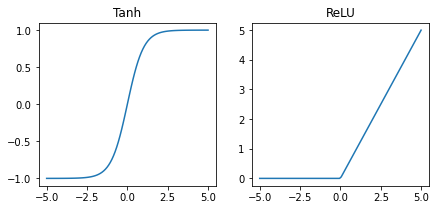

In [128]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3))

x = np.linspace(-5, 5, 100).reshape(-1, 1)

ax[0].set_title('Tanh')
ax[0].plot(x, tanh(x))

ax[1].set_title('ReLU')
ax[1].plot(x, relu(x))

### Implement forward propagation (<span style="color:green">1 point</span>)

According to the model in **Fig. 2**, our **forward propagation** consists of three parts:

First, we calculate of the output activation $A_1$ for the first hidden layer:

$$
\begin{align}
Z_1 &= W_1 X \tag{4} \\
A_1 &= {\rm ReLU}(Z_1) \tag{5}
\end{align}
$$

where $W_1$ corresponds to the weights of the first hidden layer and $X$ corresponds to the input. Here we use the **ReLU** activation function.


Then, we calculate the activation $A_2$ for the second hidden layer:

$$
\begin{align}
Z_2 &= W_2 A_1 \tag{6} \\
A_2 &= {\rm tanh}(Z_2) \tag{7}
\end{align}
$$

where $W_2$ corresponds to the weights of the second hidden layer. Here we use the **tanh** activation function.

Finally, we calculate the activation $A_3$ for the output layer:

$$
\begin{align}
Z_3 &= W_3 A_2 \tag{8} \\
A_3 &= {\rm softmax}(Z_3) \tag{9}
\end{align}
$$

where $W_3$ is the weights of the output layer. Since we are dealing with multi-class classification, we use the softmax activation for the output layer. The output $A_3$ provides the predicted probabilities for the different classes.

Now, construct the function for forward propagation in the code cell below.

In [132]:
def forward_propagation(X, parameters):
    """Method for forward propagation.
    Args:
        X (np.array): Input data
        parameters (tuple): model parameters: W1, W2, W3

    Returns:
        outputs (tuple): cached outputs of forward propagation: Z1, A1, Z2, A2, Z3, A3 (used later in backpropagation)
    """

    W1, W2, W3 = parameters

    # TODO: implement the forward propagation presented in Fig. 2 based on Eq. 4 - 9 (1 point)
    # Hint: use np.matmul() to implement matrix multiplication
    
    
    Z1 = np.matmul(W1, X)
    
    A1 = relu(Z1)
    
    Z2 = np.matmul(W2, A1)
    
    A2 = tanh(Z2)
    
    Z3 = np.matmul(W3, A2)
    
    A3 = softmax(Z3)

    outputs = Z1, A1, Z2, A2, Z3, A3
    return outputs

Check whether your output matches the reference results.

In [133]:
np.random.seed(1)
X = np.random.randn(num_inputs, 2)

parameters, _ = init_parameters(num_inputs, num_hidden_1, num_hidden_2, num_outputs)
Z1, A1, Z2, A2, Z3, A3 = forward_propagation(X, parameters)

print('Shape of X:', X.shape)
print('Shape of Z1:', Z1.shape)
print('Shape of A1:', A1.shape)
print('Shape of Z2:', Z2.shape)
print('Shape of A2:', A2.shape)
print('Shape of Z3:', Z3.shape)
print('Shape of A3:', A3.shape)

print('\nExample results of A3:')
print(A3)

Shape of X: (784, 2)
Shape of Z1: (10, 2)
Shape of A1: (10, 2)
Shape of Z2: (6, 2)
Shape of A2: (6, 2)
Shape of Z3: (10, 2)
Shape of A3: (10, 2)

Example results of A3:
[[0.09999336 0.09999259]
 [0.09998778 0.09998405]
 [0.09999789 0.10000008]
 [0.10000375 0.09999379]
 [0.10001238 0.10000443]
 [0.10000258 0.09999483]
 [0.10000033 0.1000069 ]
 [0.09998521 0.09998188]
 [0.10001478 0.10000985]
 [0.10000193 0.10003162]]


**<span style="color:green">Reference Results:</span>** <br>
Shape of X: (784, 2)<br>
Shape of Z1: (10, 2)<br>
Shape of A1: (10, 2)<br>
Shape of Z2: (6, 2)<br>
Shape of A2: (6, 2)<br>
Shape of Z3: (10, 2)<br>
Shape of A3: (10, 2)<br>

Example results of A3:<br>
[[1.38202775e-03 4.52205629e-04]<br>
 [6.15985645e-05 3.82649723e-04]<br>
 [1.48498984e-03 2.77106027e-03]<br>
 [3.63232325e-02 2.61529866e-04]<br>
 [4.89499804e-01 3.33523685e-03]<br>
 [5.90058174e-02 3.56606147e-03]<br>
 [3.93312146e-03 7.51254172e-03]<br>
 [1.09048918e-04 1.57395365e-04]<br>
 [4.05891483e-01 5.70850621e-03]<br>
 [2.30887617e-03 9.75852813e-01]]<br>

### 2.3 Loss function computation and backward propagation (<span style="color:green">2.5 points</span>)

### Implement the cross-entropy loss function (<span style="color:green">0.5 points</span>)

The cross entropy loss function is defined:

$$
L = {\rm cross\_entropy}(Y, A_3) = - \frac{1}{M} \sum_{k=0}^{M} \sum_{i=0}^{N} Y_i^{k} log({A_3}_i^{k}) \tag{10}
$$

where $Y$ corresponds to the ground truth labels, $A_3$ the predicted outputs, $N$ the number of classes, and $M$ is the number of samples in the training batch.

Implement the function for computing the cross-entropy loss in the code cell below.

In [136]:
def cross_entropy_loss(Y, Y_pred):
    # TODO: implement Eq. 10 (0.5 points)
    # Hint: use np.sum(), np.multiply(), np.log() and Y.shape[]
    
    shape = Y.shape[1]
    
    loss = -np.sum(np.multiply(Y, np.log(Y_pred))) / shape
    
    return loss

Check whether your output matches the reference results.

In [138]:
np.random.seed(1)
Y = one_hot_vector(np.random.randint(1, num_classes, 2), num_classes)
A3 = softmax(np.random.randn(num_classes, 2))

L = cross_entropy_loss(Y, A3)
print('Shape of Y:', Y.shape)
print('Shape of A3:', A3.shape)
print('Loss:', L)

Shape of Y: (10, 2)
Shape of A3: (10, 2)
Loss: 1.4200061694735258


**<span style="color:green">Reference results:</span>** <br>
Shape of Y: (10, 2)<br>
Shape of A3: (10, 2)<br>
Loss: 1.4200061694735258<br>

### Implement backward propagation (<span style="color:green">2 points</span>)

Using the chain rule of calculus, let's compute the **backward propagation** for our model in presented in **Fig. 2**. <br>

We are interested in finding out the partial derivatives $\frac{\partial L}{\partial W_1}$, $\frac{\partial L}{\partial W_2}$ and $\frac{\partial L}{\partial W_3}$ that describe how the model parameters should be changed to minimize the loss function.

Now, let's apply the chain rule to $\frac{\partial L}{\partial W_1}$, $\frac{\partial L}{\partial W_2}$ and $\frac{\partial L}{\partial W_3}$:

$$
\frac{\partial L}{\partial W_3} = \frac{\partial L}{\partial A_3} \cdot \frac{\partial A_3}{\partial Z_3} \cdot \frac{\partial Z_3}{\partial W_3} \tag{11}
$$

,

$$
\frac{\partial L}{\partial W_2} = \frac{\partial L}{\partial A_3} \cdot \frac{\partial A_3}{\partial Z_3} \cdot \frac{\partial Z_3}{\partial A_2} \cdot \frac{\partial A_2}{\partial Z_2} \cdot \frac{\partial Z_2}{\partial W_2} \tag{12}
$$

and

$$
\frac{\partial L}{\partial W_1} = \frac{\partial L}{\partial A_3} \cdot \frac{\partial A_3}{\partial Z_3} \cdot \frac{\partial Z_3}{\partial A_2} \cdot \frac{\partial A_2}{\partial Z_2} \cdot \frac{\partial Z_2} {\partial A_1} \cdot \frac{\partial A_1}{\partial Z_1} \cdot \frac{\partial Z_1}{\partial W_1} \tag{13}
$$

In the following, we will go through the details needed for computing the different partial derivatives. Don't worry about matrix form of the derivatives as they are given to you in the following.

For more details on how to compute the gradients for backpropagation, please refer to the material of lecture 4.

From **Eq. 11** we have:

The derivative of $L$ with respect to $Z_3$:

$$
dZ_3 = \frac{\partial L}{\partial Z_3} = \frac{\partial L}{\partial A_3} \cdot \frac{\partial A_3}{\partial Z_3} = A_3 - Y \tag{14}
$$

<br>

The derivative of $L$ with respect to $W_3$:

$$
d W_3 = \frac{\partial L}{\partial W_3} = \frac{\partial L}{\partial Z_3} \cdot \frac{\partial Z_3}{\partial W_3} = \frac{1}{m} d Z_3 \cdot A_2^T \tag{15}
$$

where $m$ is the number of data samples in a mini batch.

<br>


From **Eq. 12** we have:

The derivative of $L$ with respect to $A_2$:
$$
d A_2 = \frac{\partial L}{\partial A_2} = \frac{\partial L}{\partial Z_3} \cdot \frac{\partial Z_3}{\partial A_2} = W_3^T \cdot (A_3 - Y) \tag{16}
$$

The derivative of $L$ with respect to $Z_2$:

$$
\frac{d}{d x}tanh(x)=1-tanh^2(x) \:\:\: \longrightarrow \:\:\:\frac{\partial A_2}{\partial Z_2} = 1 - (A_2)^2 \tag{17}
$$

$$
d Z_2 = \frac{\partial L}{\partial Z_2} = \frac{\partial L}{\partial A_2} \cdot \frac{\partial A_2}{\partial Z_2} = d A_2 * (1 - (A_2)^2 ) \tag{18}
$$

The derivative of $L$ with respect to $W_2$:
$$
d W_2 = \frac{\partial L}{\partial W_2} = \frac{\partial L}{\partial Z_2} \cdot \frac{\partial Z_2}{\partial W_2} = \frac{1}{m} d Z_2 \cdot A_1^T \tag{19}
$$

<br>


From **Eq. 13** we have:

The derivative of $L$ with respect to $A_1$:
$$
d A_1 = \frac{\partial L}{\partial A_1} = \frac{\partial L}{\partial Z_2} \cdot \frac{\partial Z_2}{\partial A_1} = W_2^T \cdot d Z_2\tag{20}
$$

The derivative of $L$ with respect to $Z_1$:
$$
\frac{\partial A_1}{\partial Z_1} = {\rm int}(A1 > 0) \tag{21}
$$

$$
d Z_1 = \frac{\partial L}{\partial Z_1} = \frac{\partial L}{\partial A_1} \cdot \frac{\partial A_1}{\partial Z_1} = d A_1 * {\rm int}(A1 > 0) \tag{22}
$$

The derivative of $L$ with respect to $W_1$:
$$
d W_1 = \frac{\partial L}{\partial W_1} = \frac{\partial L}{\partial Z_1} \cdot \frac{\partial Z_1}{\partial W_1} = \frac{1}{m} d Z_1 \cdot X^T \tag{23}
$$

<br>


**Hint**

For the above equations:
- $A \cdot B$ denotes the matrix multiplication between matrix $A$ and $B$, it can be implementated by using `np.matmul(A, B)`.
- $A * B$ denotes the [Hadamard product](https://en.wikipedia.org/wiki/Hadamard_product_(matrices)) (element-wise product) between $A$ and $B$, which can be implemented by using `np.multiply(A, B)` or `A * B`.
- $A^T$ denotes the [transpose](https://en.wikipedia.org/wiki/Transpose) of matrix $A$, which can be implemented by using `A.T`
- ${\rm int}(A)$ denotes an operation that converts a matrix of type boolean to type integer, which can be implemented by using `A.astype(int)`.
- $m$ is the number of data samples in a mini batch.

In [141]:
def backward_propagation(X, Y, parameters, outputs):
    """Method for forward propagation.
    Args:
        X (np.array): input data
        Y (np.array): ground truth labels of input data
        parameters (tuple): model parameters: W1, W2, W3
        outputs (tuple): cached outputs of forward propagation: Z1, A1, Z2, A2, Z3, A3

    Returns:
        tuple: computed gradients: dW1, dW2, dW3
    """

    m = X.shape[1] # The number of data samples in a mini batch

    W1, W2, W3 = parameters
    Z1, A1, Z2, A2, Z3, A3 = outputs

    # TODO: calculate the derivative of L with respect to Z3 and W3 using Eq. 14 - 15 (0.5 points)
    dZ3 = A3 - Y
    dW3 = (1/m) * np.matmul(dZ3, A2.T)

    # TODO: calculate the derivative of L with respect to A2, Z2 and W2 using Eq. 16 - 19 (0.75 points)
    dA2 = np.matmul(W3.T, dZ3)
    dZ2 = dA2 * (1 - A2**2)
    dW2 = (1/m) * np.matmul(dZ2, A1.T)

    # TODO: calculate the derivative of L with respect to A1, Z1 and W1 using Eq. 20 - 23 (0.75 points)
    dA1 = np.matmul(W2.T, dZ2)
    dZ1 = dA1 * (A1 > 0)
    dW1 = (1/m) * np.matmul(dZ1, X.T)

    return dW1, dW2, dW3

Check whether your output matches the reference results.

In [143]:
np.random.seed(1)
X = np.random.randn(num_inputs, 2)
Y = np.random.randint(1, num_classes, (2, ))

parameters, _ = init_parameters(num_inputs, num_hidden_1, num_hidden_2, num_outputs)
outputs = forward_propagation(X, parameters)
dW1, dW2, dW3 = backward_propagation(X, Y, parameters, outputs)

print('Shape of dW3:', dW3.shape)
print('Shape of dW2:', dW2.shape)
print('Shape of dW1:', dW1.shape)

print('\nExample results in dW3:')
print(dW3[:, 0])

print('\nExample results in dW2:')
print(dW2[:, 0])

print('\nExample results in dW1:')
print(dW1[:, 0])

Shape of dW3: (10, 6)
Shape of dW2: (6, 10)
Shape of dW1: (10, 784)

Example results in dW3:
[0.01264511 0.01264508 0.01264509 0.01264512 0.01264509 0.01264512
 0.01264509 0.01264511 0.01264512 0.01264509]

Example results in dW2:
[ 0.00684079 -0.00677243 -0.00301518  0.00453125 -0.00347331  0.00354646]

Example results in dW1:
[ 0.00095196  0.         -0.00048794 -0.00114566 -0.00185991  0.
  0.00129042  0.          0.00079551 -0.00068118]


**<span style="color:green">Reference Results:</span>** <br>
Shape of dW3: (10, 6)<br>
Shape of dW2: (6, 10)<br>
Shape of dW1: (10, 784)<br>

Example results in dW3:<br>
[4.9942051  4.80999429 4.51023899 4.99772104 4.93469564 4.99419688<br>
 4.81378453 4.98266546 4.99669364 4.96580443]<br>

Example results in dW2:<br>
[ 0.00000000e+00  0.00000000e+00 -1.25890118e-12  0.00000000e+00<br>
 -1.62841039e-11  0.00000000e+00]<br>

Example results in dW1:<br>
[-1.45284316e-12  0.00000000e+00  4.73647801e-13 -2.40991086e-10<br>
 -4.70147641e-12  0.00000000e+00  2.25983992e-10  0.00000000e+00<br>
  7.74600535e-12  6.12156451e-11]<br>

### Extended reading: Gradient check using finite-difference approximation

When training deep neural networks, there are many things that can go wrong. Until this point, you probably notice that we have been going on and on about the gradient. Why? Because the gradient is very important. Hence, you must make sure that the calculation of your gradient is correct. A correct gradient calculation won't promise your model will converge, but if the calculation was wrong your model will perform very weird. This type of error is hard to debug, so we better prevent it beforehand. <br>
To perform the gradient check, we can calculate gradient using the [finite-difference approximation](https://en.wikipedia.org/wiki/Finite_difference) (FDA), and let's call the output of FDA numerical gradients. Then we compare the numerical gradients with the gradient we calculate from taking the derivative. If the differences between them are small enough, we can assume that the gradient was calculated correctly. <br>

You probably learned about FDA in your undergraduate, but to refresh your mind, let's have a simple example to see how FDA works. Assume that we have a function $f(x)$ which <br>

\begin{align}
f(x) = \frac{1}{3} x^3 - \frac{1}{2} x^2 + 1 \tag{24}
\end{align}

Then, the derivative $\Delta f$ will be: <br>
\begin{align}
\Delta f = x^2 - x \tag{25}
\end{align}

At $x=2.125$, using **Eq. 25** we have $\Delta f = 2.390625$

If we calculate the numerical gradient using FDA we have:
\begin{align}
\Delta_{num\_grad} f = \frac{f(x + \epsilon) - f(x - \epsilon)}{2 * \epsilon}  \tag{26}
\end{align}

where $\epsilon$ is a very small value (E.g. $\epsilon = 1e-{04}$)

At the same point $x=2.125$, using **Eq. 20** we have $\Delta_{num\_grad} f = 2.3906250033389753$ <br>

We can see that, the calculated values of $\Delta f$ and $\Delta_{num\_grad} f$ are very close to each other. <br>

With the same idea, we can check the gradient calculation of our network using FDA. A simple way to do this is: <br>
1) We wiggle (by a very small $\epsilon$ values) the value of our weight for all of the parameters in our model. By all parameters, I mean all of the weights of $W_1$, $W_2$ and $W_3$. E.g. if we use 7 neurons in the first hidden layer and 3 neurons in the second hidden layer, the number of parameters in our network is : <br>
$num\_params(net) = num\_params(W_1) + num\_params(W_2) + num\_params(W_3) = 28*28*7 + 7*7*3 + 3*10 = 5665$ <br>
so we have to repeat the "wiggling" and calculate the numerical gradient 5665 times. At the end, we have a $num\_grad$ vector that have shape (5665,) <br>
2) Calculate the gradient by taking the derivative. Similarly, we will have a $grad$ vector that also have shape (5665,) <br>
3) Compare $num\_grad$ and $grad$ vectors by: <br>
\begin{align}
grad\_diff = \frac{||grad - num\_grad||_2}{|grad + num\_grad|_2}  \tag{27}
\end{align}

If **grad_diff** is smaller than $1e-{08}$ than we assume that our gradient calculation is correct.

## Part 3: Training and evaluation of your neural Network (<span style="color:green">2 points</span>)

### 3.1 Training the network (<span style="color:green">1.5 points</span>)

In this assignment, we will train our model using mini-batch gradient descent with momentum:  <br>

$$
v_{dW} = \beta v_{dW} + (1 - \beta) dW \tag{28}
$$

$$
W = W - \alpha v_{dW} \tag{29}
$$

where $\alpha$ is the learning rate while $\beta$ is used to update the learning velocity.

To know more about this optimization algorithm, please check out e.g. this excellent [video](https://www.youtube.com/watch?v=k8fTYJPd3_I) from Dr. Andrew Ng.

Now, fill in the missing parts in the following function that performs a single training step from forward propagation to updating the model parameters.

In [151]:
def training_step(X, Y, parameters, velocity, learning_rate, beta, weight_decay_lambda=0.):
    """Method for each training step.
    Args:
        X (np.array): training data
        Y (np.array): ground truth labels of training data
        parameters (tuple): model parameters: W1, W2, W3
        velocity (tuple): learning velocity of momentum: V_dW1, V_dW2, V_dW3
        learning_rate (float): learning rate for training
        beta (float): coefficient for updating the learning velocity
        weight_decay_lambda (float): coefficient for weight decay (an extra feature that will be defined later)

    Returns:
        tuple: loss, updated parameters, updated velocity
    """

    W1, W2, W3 = parameters

    # Forward propagation
    outputs = forward_propagation(X, parameters)
    A3 = outputs[-1]

    # Loss computation and backward propagation
    if weight_decay_lambda == 0.:
        loss = cross_entropy_loss(Y, A3)
        dW1, dW2, dW3 = backward_propagation(X, Y, parameters, outputs)
    else:
        # Loss and backpropagation with weight decay are extra tasks introduced in part 4.1
        loss = cross_entropy_loss(Y, A3) + weight_decay_loss(parameters, weight_decay_lambda)
        dW1, dW2, dW3 = backward_propagation_with_weight_decay(X, Y, parameters, outputs, weight_decay_lambda)

    V_dW1, V_dW2, V_dW3 = velocity

    # Model parameter update
    # TODO: update the learning velocity using Eq. 28 (0.75 points)
    V_dW1 = beta * V_dW1 + (1 - beta) * dW1
    V_dW2 = beta * V_dW2 + (1 - beta) * dW2
    V_dW3 = beta * V_dW3 + (1 - beta) * dW3

    # TODO: update the model parameters using Eq. 29 (0.75 points)
    W1 = W1 - learning_rate * V_dW1
    W2 = W2 - learning_rate * V_dW2
    W3 = W3 - learning_rate * V_dW3

    parameters = W1, W2, W3
    velocity = V_dW1, V_dW2, V_dW3

    return loss, parameters, velocity

Let's define the function for training our model.

In [153]:
def training_model(parameters, velocity, batch_size, epoch, learning_rate, beta, weight_decay_lambda=0.):

    # Calculate the number of training iterations base on the number of training samples and your batch size
    num_batches = num_trains // batch_size
    print('Start training the model:')
    print('Number of training samples: {}'.format(num_trains))
    print('Number of batchs: {}'.format(num_batches))

    loss_log = [] # Log the training loss

    # Training
    for i in range(epoch):
        start_t = time.time()

        indices = np.random.permutation(num_trains)
        X_train_shuffled, Y_train_shuffled = X_train[:, indices], Y_train[:, indices]

        for j in range(num_batches):

            # Get mini-batch samples for training
            start_idx, end_idx = j * batch_size, min(j * batch_size + batch_size, X_train.shape[1] - 1)
            X, Y = X_train_shuffled[:, start_idx : end_idx], Y_train_shuffled[:, start_idx : end_idx]

            # Call training_step()
            loss, parameters, velocity = training_step(X, Y, parameters, velocity, learning_rate, beta, weight_decay_lambda)

            loss_log.append(loss)
            if (j > 0 and j % 200 == 0):
                print("[Epoch][Iterations]:[{}/{}][{}/{}], loss: {}".format(i, epoch, j, num_batches, loss))

        print("=> Epoch {}, elapsed time: {:.2f} seconds".format(i, time.time() - start_t))

    plt.title('Training loss:')
    plt.plot(loss_log)
    plt.show()

    return parameters

Finally, we initialize the model and train the model with default parameters.

Start training the model:
Number of training samples: 60000
Number of batchs: 468
[Epoch][Iterations]:[0/30][200/468], loss: 1.6988037341578606
[Epoch][Iterations]:[0/30][400/468], loss: 1.2415276980113914
=> Epoch 0, elapsed time: 0.29 seconds
[Epoch][Iterations]:[1/30][200/468], loss: 0.9833254952969528
[Epoch][Iterations]:[1/30][400/468], loss: 0.8669729803858799
=> Epoch 1, elapsed time: 0.33 seconds
[Epoch][Iterations]:[2/30][200/468], loss: 0.5983534104854615
[Epoch][Iterations]:[2/30][400/468], loss: 0.5123567384884935
=> Epoch 2, elapsed time: 0.36 seconds
[Epoch][Iterations]:[3/30][200/468], loss: 0.6135723264901931
[Epoch][Iterations]:[3/30][400/468], loss: 0.4846003002966086
=> Epoch 3, elapsed time: 0.40 seconds
[Epoch][Iterations]:[4/30][200/468], loss: 0.5620245644813485
[Epoch][Iterations]:[4/30][400/468], loss: 0.45041753818451746
=> Epoch 4, elapsed time: 0.43 seconds
[Epoch][Iterations]:[5/30][200/468], loss: 0.5642975876448796
[Epoch][Iterations]:[5/30][400/468], los

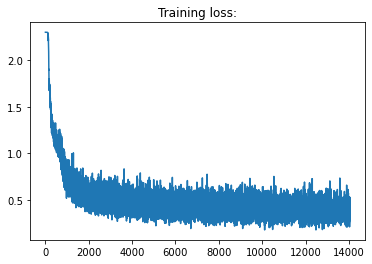

In [155]:
np.random.seed(1)

parameters, velocity = init_parameters(
    num_inputs = X_train.shape[0],
    num_hidden_1 = 10,
    num_hidden_2 = 6,
    num_outputs = num_classes,
)

trained_parameters = training_model(
    parameters,
    velocity,
    batch_size = 128,
    epoch = 30,
    learning_rate = 0.25,
    beta = 0.5,
    weight_decay_lambda = 0.,
)

### 3.2 Evaluate the performance of your model (<span style="color:green">0.5 points</span>)

Implement the forward propagation step for testing the model performance in the code cell below.

In [156]:
def testing_model(X, parameters):
    # TODO: implement the forward propagation for testing step (0.5 points)
    # Hint: call forward_propagation() function and get the output A3
    A3 = forward_propagation(X, parameters)[-1]

    # Evaluate the performance of your model
    predictions = np.argmax(A3, axis=0)
    labels = np.argmax(Y_test, axis=0)

    print("Confusion matrix:\n{}\n".format(confusion_matrix(labels, predictions)))
    print("Test accuracy: {}".format(accuracy_score(labels, predictions)))

Let's test the accuracy of our model.

In [157]:
testing_model(X_test, trained_parameters)

Confusion matrix:
[[849   1  23  22   2   5  85   0  13   0]
 [  8 954   8  23   3   0   1   0   1   2]
 [ 17   3 818   4  67   3  77   0  11   0]
 [ 56  24  27 818  34   2  36   0   3   0]
 [  0   3 237  28 646   1  80   0   5   0]
 [  2   0   0   0   0 927   1  39   5  26]
 [198   3 131  22  74   5 548   0  19   0]
 [  0   0   0   0   0  24   0 940   0  36]
 [  7   0   9   4   6  14  20   5 933   2]
 [  0   1   0   0   0  12   0  41   1 945]]

Test accuracy: 0.8378


The test accuracy should be around 0.70.

## Part 4: Regularization and hyperparameter tuning (<span style="color:green">2.5 points</span>)

### 4.1 Implement weight decay loss and backward propagation  (<span style="color:green">1.5 points</span>)

[Regularization](https://en.wikipedia.org/wiki/Regularization_(mathematics)) is a set of techniques in deep learning to prevent overfitting by adding a penalty term to the loss function, discouraging overly complex models, and promoting simpler, more generalizable ones. The loss function in regularization incorporates additional terms, like L1 or L2 regularization, which penalize large weights or complex models to prevent overfitting.

To implement weight decay (L2) regularization in our neural network, we can modify the loss function as follows:

$$
\begin{align}
L &= L_1 + L_2 \tag{30} \\
\\
L_1 &= {\rm cross\_entropy}(Y, A_3) \tag{31} \\
L_2 &= \frac{\lambda}{2} \left( ||W_1||_2^2 + ||W_2||_2^2 + ||W_3||_2^2 \right) \tag{32}
\end{align}
$$

Here $L_2$ denotes the weight decay loss, and $||\cdot||_2^2$ is the [L2 regularization](https://en.wikipedia.org/wiki/Regularization_(mathematics)). For example, $||W_1||_2^2$ is calculated by:
$$
||W_1||_2^2 = \sum_{i=1}^{N}\sum_{j=1}^{M}{W_1^{(ij)}}^2
$$
which directly sums the squares of all elements in $W_1$.

Implement the weight decay loss in the code cell below.

In [161]:
def weight_decay_loss(parameters, lambd):
    """
    Args:
        parameters (tuple): model parameters: W1, W2, W3
        lambd (float): coefficient of weight decay
    """
    W1, W2, W3 = parameters

    # TODO: implement the weight decay loss in Eq. 32 (0.75 points)
    # Hint: use np.sum() and np.power()
    
    lambd = lambd * 10000
    
    L2_W1 = np.sum(np.power(W1, 2))
    L2_W2 = np.sum(np.power(W2, 2))
    L2_W3 = np.sum(np.power(W3, 2))
    
    L2_loss = (lambd / 2) * (L2_W1 + L2_W2 + L2_W3) 
    
    
    return L2_loss

Check whether your output matches the reference results.

In [162]:
np.random.seed(1)
parameters, _ = init_parameters(num_inputs, num_hidden_1, num_hidden_2, num_outputs)

loss = weight_decay_loss(parameters, lambd=0.0001)
print('loss:', loss)

loss: 0.3972738208879281


**<span style="color:green">Reference Results:</span>** <br>
loss: 0.3972738208879281

Since we now use a new loss function $L$, we need to calculate the derivative $L$ with respect to $W_1, W_2, W_3$ for backward propagation again.

Take $W_1$ as an example, the derivative of $L$ with respect to $W_1$ is calculated by:
$$
\begin{align}
d W_{1(new)} &= \frac{\partial L}{\partial W_1} = \frac{\partial L_1}{\partial W_1} + \frac{\partial L_2}{\partial W_1} = dW_1 + \lambda W_1 \tag{33}
\end{align}
$$

Here $dW_1$ is the previous derivative same as Eq. 23.

Now, complete the function for performing backpropagation with weight decay.

In [166]:
def backward_propagation_with_weight_decay(X, Y, parameters, outputs, lambd):
    """Method for forward propagation.
    Args:
        X (np.array): input data
        Y (np.array): ground truth labels of input data
        parameters (tuple): model parameters: W1, W2, W3
        outputs (tuple): cached outputs of forward propagation: Z1, A1, Z2, A2, Z3, A3
        lambd (float): coefficient of weight decay

    Returns:
        tuple: computed gradients: dW1, dW2, dW3
    """

    W1, W2, W3 = parameters
    dW1, dW2, dW3 = backward_propagation(X, Y, parameters, outputs)

    # TODO: calculate the new derivative of L with respect to W1, W2 and W3 based on Eq. 33 (0.75 points)
    
    dW3_new = abs(dW1 + lambd * W1)
    dW2_new = abs(dW2 + lambd * W2)
    dW1_new = abs(dW3 + lambd * W3)

    return dW1_new, dW2_new, dW3_new

Check whether your output matches the reference results.

In [170]:
np.random.seed(1)
X = np.random.randn(num_inputs, 2)
Y = np.random.randint(1, num_classes, (2, ))

parameters, _ = init_parameters(num_inputs, num_hidden_1, num_hidden_2, num_outputs)
outputs = forward_propagation(X, parameters)
dW1_new, dW2_new, dW3_new = backward_propagation_with_weight_decay(X, Y, parameters, outputs, lambd=0.0001)

print('\nExample results in dW3 (new):')
print(dW3_new[:, 0])

print('\nExample results in dW2 (new):')
print(dW2_new[:, 0])

print('\nExample results in dW1 (new):')
print(dW1_new[:, 0])


Example results in dW3 (new):
[9.52515026e-04 1.89067615e-07 4.88128651e-04 1.14593066e-03
 1.85780211e-03 1.05074359e-06 1.29010695e-03 4.55281440e-07
 7.96228659e-04 6.79302100e-04]

Example results in dW2 (new):
[0.00684258 0.00677225 0.0030146  0.00453048 0.00347292 0.00354652]

Example results in dW1 (new):
[0.01264482 0.01264541 0.01264404 0.01264491 0.01264488 0.01264536
 0.01264436 0.01264389 0.01264445 0.01264446]


**<span style="color:green">Reference Results:</span>** <br>
Example results in dW3 (new):<br>
[4.99417602 4.81002709 4.51013425 4.99769988 4.93467474 4.99422092<br>
 4.81371188 4.98254415 4.99662634 4.96574142]<br>

Example results in dW2 (new):<br>
[ 1.78778996e-04  1.80471533e-05  5.78735665e-05 -7.65603509e-05<br>
  3.89918617e-05  5.60040836e-06]<br>

Example results in dW1 (new):<br>
[ 5.51204348e-05  1.89067615e-05 -1.87286483e-05 -2.72250057e-05<br>
  2.10901799e-04  1.05074359e-04 -3.10534150e-05  4.55281440e-05<br>
  7.14239094e-05  1.88094599e-04]<br>

### 4.2 Hyperparameter tuning (<span style="color:green">1 point</span>)

[Hyperparameter tuning](https://en.wikipedia.org/wiki/Hyperparameter_optimization) is an effective way to optimize the performance of your models in machine learning.

In the case of our neural network, we can adjust many hyperparameters, such as learning rate, batch size, weight decay coefficient, number of training epochs, and the model architecture (i.e. number of neurons in the hidden layers).

Play with the hyperparameters and try to improve the performance (test accuracy) of your neural network above 0.80.

Start training the model:
Number of training samples: 60000
Number of batchs: 468
[Epoch][Iterations]:[0/30][200/468], loss: 2.279404008593956
[Epoch][Iterations]:[0/30][400/468], loss: 1.2102757978901812
=> Epoch 0, elapsed time: 0.28 seconds
[Epoch][Iterations]:[1/30][200/468], loss: 1.022915576439643
[Epoch][Iterations]:[1/30][400/468], loss: 0.7309065217255504
=> Epoch 1, elapsed time: 0.31 seconds
[Epoch][Iterations]:[2/30][200/468], loss: 0.6874868415970738
[Epoch][Iterations]:[2/30][400/468], loss: 0.667186125466934
=> Epoch 2, elapsed time: 0.32 seconds
[Epoch][Iterations]:[3/30][200/468], loss: 0.7491363894986163
[Epoch][Iterations]:[3/30][400/468], loss: 0.6589206879392571
=> Epoch 3, elapsed time: 0.31 seconds
[Epoch][Iterations]:[4/30][200/468], loss: 0.5821173929446325
[Epoch][Iterations]:[4/30][400/468], loss: 0.6027677444458285
=> Epoch 4, elapsed time: 0.33 seconds
[Epoch][Iterations]:[5/30][200/468], loss: 0.6258544523220533
[Epoch][Iterations]:[5/30][400/468], loss: 0

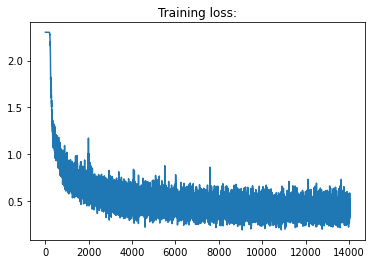

In [188]:
# TODO: adjust the values of hyperparameters below and try to improve the test accuracy. (1 point)
# Hint: try to adjust 'num_hidden_X', 'weight_decay_lambda' and/or other hyperparameters

parameters, velocity = init_parameters(
    num_inputs = X_train.shape[0],
    num_hidden_1 = 10,
    num_hidden_2 = 7,
    num_outputs=num_classes
)

trained_parameters = training_model(
    parameters,
    velocity,
    batch_size = 128,
    epoch = 30,
    learning_rate = 0.25,
    beta = 0.5,
    weight_decay_lambda = 0.0,
)

In [189]:
testing_model(X_test, trained_parameters)

Confusion matrix:
[[807   7  12 102   3   1  57   1  10   0]
 [  0 963   9  22   4   0   1   0   1   0]
 [ 16   4 757  13 154   2  50   0   4   0]
 [ 12  26   8 895  26   0  26   0   7   0]
 [  1   0 111  48 788   1  45   0   6   0]
 [  0   0   0   1   0 939   1  31   7  21]
 [163   3 139  79 130   0 477   0   9   0]
 [  0   0   0   0   0  39   0 889   3  69]
 [  6   0   6   5   7   6  17   4 949   0]
 [  0   0   0   0   0  21   0  16   1 962]]

Test accuracy: 0.8426


**<span style="color:green">Reference Results:</span>** <br>
Test accuracy: 0.80 or better<br>